In [1]:
!pip install imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 18.5 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
from skimage import io, filters, measure, morphology, color
import tifffile
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- CONFIGURATION ---
folder_path = '/content/drive/My Drive/856/Positive_x40/'
output_path = os.path.join(folder_path, 'Analysis_Results')
os.makedirs(output_path, exist_ok=True)

def safe_load(path):
    """Robustly load TIFs even if they are compressed or have OME metadata issues."""
    try:
        with tifffile.TiffFile(path) as tif:
            # Take the first page only to avoid issues with multi-page/missing frames
            img = tif.pages[0].asarray()
        return img
    except Exception as e:
        print(f"Error loading {os.path.basename(path)}: {e}")
        return None

def run_analysis():
    all_files = [f for f in os.listdir(folder_path) if f.upper().endswith('.TIF')]
    dapi_files = [f for f in all_files if 'd0.' in f.lower()]

    print(f"✅ Path found. Total .TIF files: {len(all_files)}")
    print(f"✅ DAPI sets identified: {len(dapi_files)}")

    results = []

    for dapi_name in dapi_files:
        # Base name logic based on your example: Negative_x40_Bottom Slide_R_p00_0_A01f00d0.TIF
        # We find where 'd0' starts and take everything before it
        base_part = dapi_name[:dapi_name.lower().find('d0')]

        f_gfp   = next((f for f in all_files if f.startswith(base_part) and 'd1' in f.lower()), None)
        f_cy5   = next((f for f in all_files if f.startswith(base_part) and 'd3' in f.lower()), None)
        f_phase = next((f for f in all_files if f.startswith(base_part) and 'd4' in f.lower()), None)

        if not all([f_gfp, f_cy5, f_phase]):
            continue

        print(f"Processing: {base_part}")

        # Load images safely
        img_dapi  = safe_load(os.path.join(folder_path, dapi_name))
        img_gfp   = safe_load(os.path.join(folder_path, f_gfp))
        img_cy5   = safe_load(os.path.join(folder_path, f_cy5))
        img_phase = safe_load(os.path.join(folder_path, f_phase))

        if img_dapi is None or img_gfp is None: continue

        # --- SEGMENTATION ---
        # DAPI thresholding (HHB)
        thresh_val = filters.threshold_otsu(img_dapi)
        mask_dapi = img_dapi > thresh_val
        mask_dapi = morphology.remove_small_objects(mask_dapi, 300) # Remove noise
        labels_hhb = measure.label(mask_dapi)

        # GFP thresholding (Agarose Core)
        mask_gfp = img_gfp > filters.threshold_otsu(img_gfp)

        # --- VISUALIZATION ---
        # Create a nice overlay for checking
        p_low, p_high = np.percentile(img_phase, (1, 99))
        phase_norm = np.clip((img_phase - p_low) / (p_high - p_low), 0, 1)
        vis_img = color.gray2rgb(phase_norm)

        # Color masks: Blue for DAPI, Green for GFP
        vis_img[mask_dapi, 2] = 0.8
        vis_img[mask_gfp, 1] = 0.8

        clean_base = base_part.strip('_')
        io.imsave(os.path.join(output_path, f"{clean_base}_overlay.png"), (vis_img * 255).astype(np.uint8))

        # --- QUANTIFICATION ---
        props = measure.regionprops(labels_hhb)
        for prop in props:
            mask_this_bead = (labels_hhb == prop.label)

            # Intersection (Core)
            core_mask = np.logical_and(mask_this_bead, mask_gfp)
            # Subtraction (Ring)
            ring_mask = np.logical_and(mask_this_bead, ~mask_gfp)

            results.append({
                'Source': clean_base,
                'Bead_ID': prop.label,
                'CY5_Core_Mean': np.mean(img_cy5[core_mask]) if np.any(core_mask) else 0,
                'CY5_Ring_Mean': np.mean(img_cy5[ring_mask]) if np.any(ring_mask) else 0,
                'Core_Area_px': np.sum(core_mask),
                'Ring_Area_px': np.sum(ring_mask)
            })

    if results:
        df = pd.DataFrame(results)
        df.to_csv(os.path.join(output_path, 'intensity_analysis.csv'), index=False)
        print(f"\n✨ FINISHED! Results saved to: {output_path}")
    else:
        print("❌ No beads were detected in any files.")

run_analysis()

✅ Path found. Total .TIF files: 52
✅ DAPI sets identified: 13
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f13
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f14
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f15
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f16
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f17
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f18
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f19
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f20
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f22
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f21
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f23
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f24
Processing: Positive_x40_Bottom Slide_R_p00_0_A01f25

✨ FINISHED! Results saved to: /content/drive/My Drive/856/Positive_x40/Analysis_Results


# **Draw swarplot **

--- Summary Statistics ---
      Group  count        mean         std
0  Negative     28  849.002785  293.216577
1  Positive     29  968.940218  224.712187


/tmp/ipython-input-2805470198.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='Group_with_n', y='CY5_Ring_Mean', data=df_filtered,


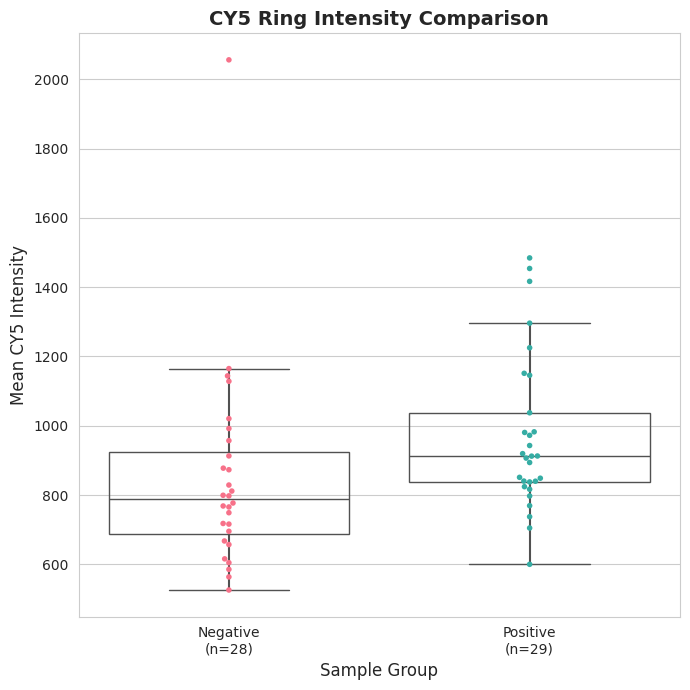

✅ Plot with sample sizes saved to: /content/drive/My Drive/856/comparison_swarm_plot_with_n.png


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
neg_csv_path = '/content/drive/My Drive/856/Negative_x40/Analysis_Results/intensity_analysis.csv'
pos_csv_path = '/content/drive/My Drive/856/Positive_x40/Analysis_Results/intensity_analysis.csv'
output_plot_path = '/content/drive/My Drive/856/comparison_swarm_plot_with_n.png'

def generate_swarm_plot():
    # 1. Load the data
    if not os.path.exists(neg_csv_path) or not os.path.exists(pos_csv_path):
        print("❌ Error: One or both CSV files were not found.")
        return

    df_neg = pd.read_csv(neg_csv_path)
    df_pos = pd.read_csv(pos_csv_path)

    # 2. Label and Combine
    df_neg['Group'] = 'Negative'
    df_pos['Group'] = 'Positive'
    df_combined = pd.concat([df_neg, df_pos], ignore_index=True)

    # 3. Filter: CY5_Core_Mean > 2500
    df_filtered = df_combined[df_combined['CY5_Core_Mean'] > 2500].copy()

    # 4. Calculate Sample Sizes and Statistics
    stats = df_filtered.groupby('Group')['CY5_Ring_Mean'].agg(['count', 'mean', 'std']).reset_index()
    print("--- Summary Statistics ---")
    print(stats)

    # Create dynamic labels: "Negative (n=120)"
    n_labels = {row['Group']: f"{row['Group']}\n(n={int(row['count'])})" for _, row in stats.iterrows()}
    df_filtered['Group_with_n'] = df_filtered['Group'].map(n_labels)

    # 5. Create the Plot
    plt.figure(figsize=(7, 7))
    sns.set_style("whitegrid")

    # Sort order to ensure Negative is first
    plot_order = [n_labels['Negative'], n_labels['Positive']]

    # Swarmplot
    sns.swarmplot(x='Group_with_n', y='CY5_Ring_Mean', data=df_filtered,
                  palette='husl', size=4, order=plot_order)

    # Boxplot overlay
    sns.boxplot(x='Group_with_n', y='CY5_Ring_Mean', data=df_filtered,
                order=plot_order, showcaps=True, boxprops={'facecolor':'None'},
                showfliers=False, whiskerprops={'linewidth':1.5})

    plt.title('CY5 Ring Intensity Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Mean CY5 Intensity', fontsize=12)
    plt.xlabel('Sample Group', fontsize=12)

    # 6. Save and show
    plt.tight_layout()
    plt.savefig(output_plot_path, dpi=300)
    plt.show()

    print(f"✅ Plot with sample sizes saved to: {output_plot_path}")

generate_swarm_plot()

--- Statistics Summary ---
Normality (p > 0.05 is normal): Neg=0.000, Pos=0.009
Test Used: Mann-Whitney U
P-value: 0.00864
Effect Size (Cohen's d): 0.460


/tmp/ipython-input-2992909293.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.swarmplot(x='Label', y='CY5_Ring_Mean', data=df_filtered,


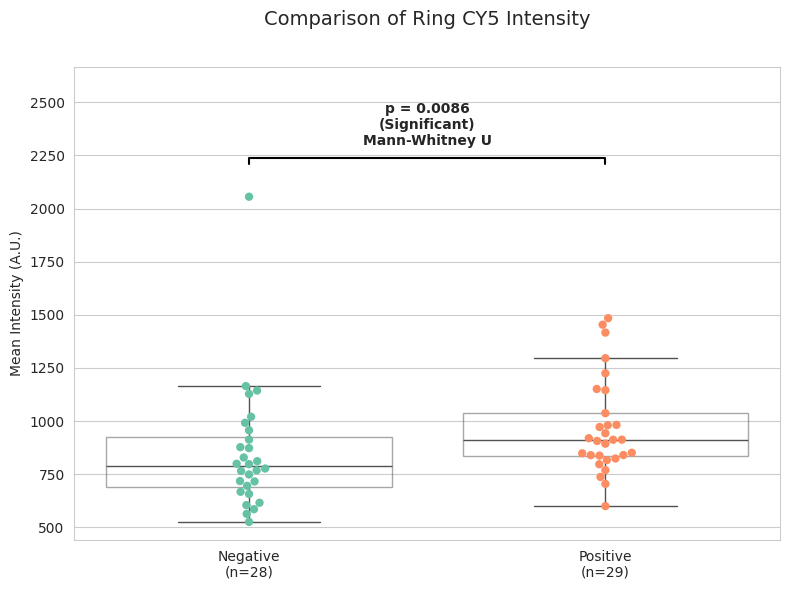

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os
import numpy as np

# --- CONFIGURATION ---
neg_csv_path = '/content/drive/My Drive/856/Negative_x40/Analysis_Results/intensity_analysis.csv'
pos_csv_path = '/content/drive/My Drive/856/Positive_x40/Analysis_Results/intensity_analysis.csv'
output_plot_path = '/content/drive/My Drive/856/statistical_comparison_plot.png'

def calculate_cohen_d(group1, group2):
    """Calculates the effect size (Cohen's d)"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

def run_stats_and_plot():
    # 1. Load and Filter
    df_neg = pd.read_csv(neg_csv_path)
    df_pos = pd.read_csv(pos_csv_path)
    df_neg['Group'] = 'Negative'
    df_pos['Group'] = 'Positive'

    df_combined = pd.concat([df_neg, df_pos], ignore_index=True)
    df_filtered = df_combined[df_combined['CY5_Core_Mean'] > 2500].copy()  ### set threshold for core_mean ###

    neg_vals = df_filtered[df_filtered['Group'] == 'Negative']['CY5_Ring_Mean'].values
    pos_vals = df_filtered[df_filtered['Group'] == 'Positive']['CY5_Ring_Mean'].values

    # 2. Run Assumption Tests
    _, p_norm_neg = stats.shapiro(neg_vals)
    _, p_norm_pos = stats.shapiro(pos_vals)
    _, p_levene = stats.levene(neg_vals, pos_vals)

    # 3. Select Appropriate Test
    is_normal = (p_norm_neg > 0.05) and (p_norm_pos > 0.05)

    if is_normal:
        # T-test
        equal_var = (p_levene > 0.05)
        test_name = "Student's t-test" if equal_var else "Welch's t-test"
        t_stat, p_val = stats.ttest_ind(neg_vals, pos_vals, equal_var=equal_var)
    else:
        # Non-parametric
        test_name = "Mann-Whitney U"
        u_stat, p_val = stats.mannwhitneyu(neg_vals, pos_vals, alternative='two-sided')

    d_val = calculate_cohen_d(pos_vals, neg_vals)

    # Print Summary
    print(f"--- Statistics Summary ---")
    print(f"Normality (p > 0.05 is normal): Neg={p_norm_neg:.3f}, Pos={p_norm_pos:.3f}")
    print(f"Test Used: {test_name}")
    print(f"P-value: {p_val:.5f}")
    print(f"Effect Size (Cohen's d): {d_val:.3f}")

    # 4. Plotting
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")

    # Custom Labels
    labels = [f"Negative\n(n={len(neg_vals)})", f"Positive\n(n={len(pos_vals)})"]
    df_filtered['Label'] = df_filtered['Group'].map({
    'Negative': labels[0],
    'Positive': labels[1]
})

    ax = sns.swarmplot(x='Label', y='CY5_Ring_Mean', data=df_filtered,
                   palette='Set2', size=6, order=labels)
    sns.boxplot(x='Label', y='CY5_Ring_Mean', data=df_filtered, order=labels,
                showcaps=True, boxprops={'facecolor':'None', 'alpha':0.5}, showfliers=False)

    # Add Significance Annotation
    y_max = df_filtered['CY5_Ring_Mean'].max()
    y_range = y_max - df_filtered['CY5_Ring_Mean'].min()
    line_y = y_max + (y_range * 0.1)

    # Draw bracket
    plt.plot([0, 0, 1, 1], [line_y, line_y + (y_range*0.02), line_y + (y_range*0.02), line_y], lw=1.5, c='k')

    # Annotation text
    sig_label = "Significant" if p_val < 0.05 else "Not Significant"
    plt.text(0.5, line_y + (y_range*0.05), f"p = {p_val:.4f}\n({sig_label})\n{test_name}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title('Comparison of Ring CY5 Intensity', fontsize=14, pad=30)
    plt.ylabel('Mean Intensity (A.U.)')
    plt.xlabel('')
    plt.ylim(None, line_y + (y_range * 0.3))

    plt.tight_layout()
    plt.savefig(output_plot_path, dpi=300)
    plt.show()

run_stats_and_plot()